# Dataset Comparison and Metrics Analysis

This notebook compares different validation datasets against the reference dataset (`df_correct_validation`) and calculates key performance metrics including precision, recall, F1-score, and confusion matrices.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score,
    roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Load Reference Dataset

The reference dataset (`df_correct_validation`) will be used as the ground truth for comparison.


In [ ]:
# Load reference dataset
df_correct_validation = pd.read_csv("dataset/validation_data_simple_labeled.csv")
print(f"Reference dataset shape: {df_correct_validation.shape}")
print(f"Reference dataset columns: {df_correct_validation.columns.tolist()}")
df_correct_validation.head()


Reference dataset shape: (4956, 5)
Reference dataset columns: ['label', 'title', 'text', 'subject', 'date']


,label,title,text,subject,date
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


## Load All Validation Datasets for Comparison


In [ ]:
# Load all validation datasets
datasets = {
    'First Classifier': pd.read_csv("dataset/validation_data_labeled.csv"),
    'Embeddings': pd.read_csv("dataset/validation_data_labeled_embeddings.csv"),
    'Advanced Embeddings': pd.read_csv("dataset/validation_data_labeled_embeddings_advanced.csv"),
    'Minus Reuters': pd.read_csv("dataset/validation_data_labeled_minus_reuters.csv"),
    'XGBoost': pd.read_csv("dataset/validation_XGBoost_labeled_data.csv")
}

# Display dataset information
for name, df in datasets.items():
    print(f"{name}: {df.shape}")
    if 'label' in df.columns:
        print(f"  Label distribution: {df['label'].value_counts().to_dict()}")
    print()


First Classifier: (4956, 5)
  Label distribution: {0: 3484, 1: 1472}

Embeddings: (4956, 5)
  Label distribution: {0: 3235, 1: 1721}

Advanced Embeddings: (4956, 5)
  Label distribution: {0: 4398, 1: 558}

Minus Reuters: (4956, 10)
  Label distribution: {0: 3193, 1: 1763}

XGBoost: (4956, 5)
  Label distribution: {0: 3501, 1: 1455}



## Label Distribution Visualization

Create pie charts showing the distribution of labels (0 and 1) for each dataset.


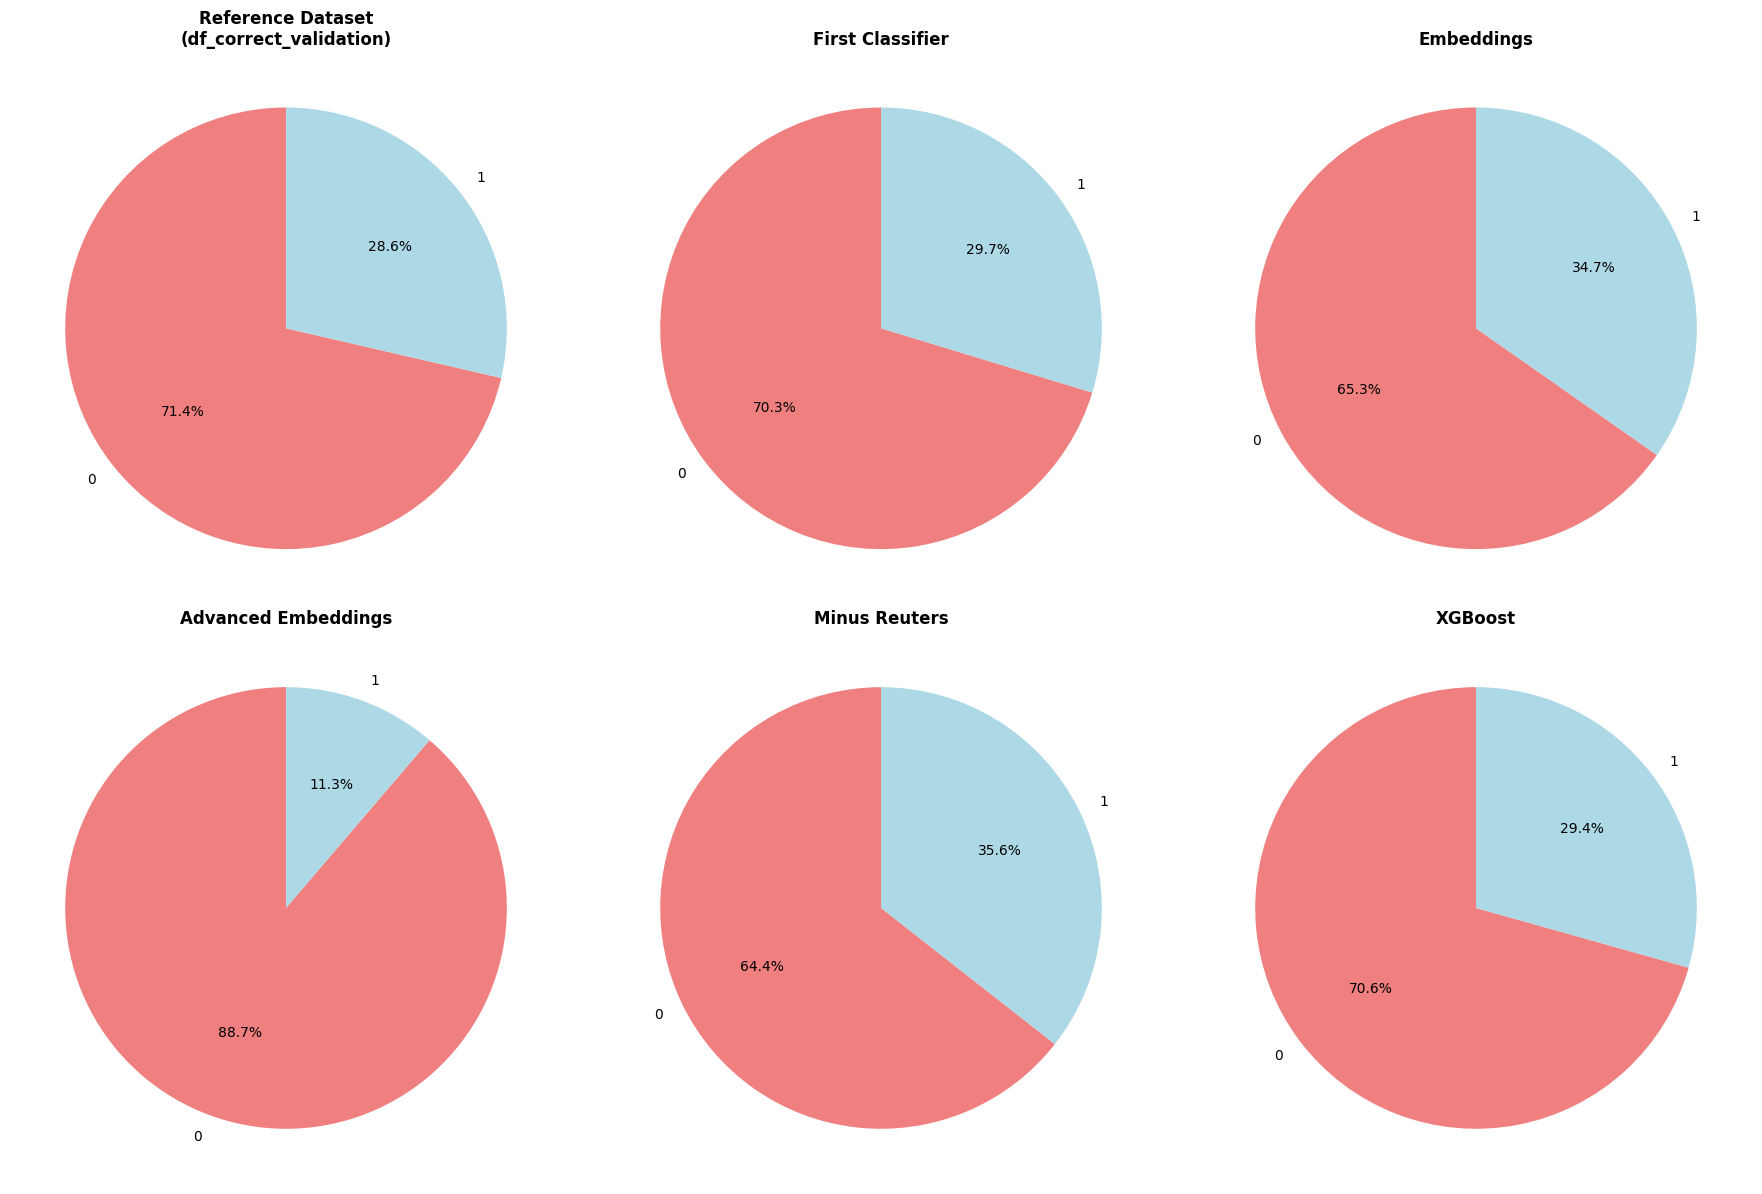

In [ ]:
# Create pie charts for all datasets
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Reference dataset
counts = df_correct_validation['label'].value_counts()
labels = ['0', '1']
sizes = [counts.get(0, 0), counts.get(1, 0)]
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
           colors=['lightcoral', 'lightblue'])
axes[0].set_title('Reference Dataset\n(df_correct_validation)', fontsize=12, fontweight='bold')

# Other datasets
dataset_names = list(datasets.keys())
for i, (name, df) in enumerate(datasets.items(), 1):
    if 'label' in df.columns:
        counts = df['label'].value_counts()
        sizes = [counts.get(0, 0), counts.get(1, 0)]
        axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
                   colors=['lightcoral', 'lightblue'])
        axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, 'No label column', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{name}\n(No labels)', fontsize=12, fontweight='bold')

# Hide the last subplot if not needed
if len(datasets) < 5:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


## Metrics Calculation Function

Define a function to calculate all relevant metrics for comparison.


In [ ]:
def calculate_metrics(y_true, y_pred, dataset_name):
    """
    Calculate comprehensive metrics for model evaluation
    """
    try:
        # Ensure both arrays have the same length
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Calculate per-class metrics
        precision_0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
        recall_0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
        f1_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
        
        precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        
        # Try to calculate AUC (might fail if only one class present)
        try:
            auc = roc_auc_score(y_true, y_pred)
        except:
            auc = np.nan
        
        return {
            'Dataset': dataset_name,
            'Accuracy': accuracy,
            'Precision (Weighted)': precision,
            'Recall (Weighted)': recall,
            'F1-Score (Weighted)': f1,
            'Precision (Class 0)': precision_0,
            'Recall (Class 0)': recall_0,
            'F1-Score (Class 0)': f1_0,
            'Precision (Class 1)': precision_1,
            'Recall (Class 1)': recall_1,
            'F1-Score (Class 1)': f1_1,
            'AUC': auc,
            'Total Samples': len(y_true)
        }
    except Exception as e:
        print(f"Error calculating metrics for {dataset_name}: {e}")
        return None


## Calculate Metrics for All Datasets

Compare each dataset against the reference dataset and calculate comprehensive metrics.


In [ ]:
# Calculate metrics for all datasets
metrics_results = []

# Get reference labels
reference_labels = df_correct_validation['label'].values

for name, df in datasets.items():
    if 'label' in df.columns:
        print(f"Calculating metrics for {name}...")
        dataset_labels = df['label'].values
        
        # Calculate metrics
        metrics = calculate_metrics(reference_labels, dataset_labels, name)
        if metrics:
            metrics_results.append(metrics)
    else:
        print(f"Skipping {name} - no 'label' column found")

# Create metrics DataFrame
if metrics_results:
    metrics_df = pd.DataFrame(metrics_results)
    print("\nMetrics calculated successfully!")
else:
    print("No metrics could be calculated.")


Calculating metrics for First Classifier...
Calculating metrics for Embeddings...
Calculating metrics for Advanced Embeddings...
Calculating metrics for Minus Reuters...
Calculating metrics for XGBoost...

Metrics calculated successfully!


## Metrics Summary Table

Display all calculated metrics in a comprehensive table.


In [ ]:
if 'metrics_df' in locals():
    # Display the metrics table
    print("\n" + "="*80)
    print("COMPREHENSIVE METRICS COMPARISON")
    print("="*80)
    
    # Round numeric columns for better readability
    numeric_columns = metrics_df.select_dtypes(include=[np.number]).columns
    metrics_df_display = metrics_df.copy()
    metrics_df_display[numeric_columns] = metrics_df_display[numeric_columns].round(4)
    
    display(metrics_df_display)
    
    # Save to CSV
    metrics_df.to_csv('dataset_comparison_metrics.csv', index=False)
    print("\nMetrics saved to 'dataset_comparison_metrics.csv'")
else:
    print("No metrics data available to display.")



COMPREHENSIVE METRICS COMPARISON


,Dataset,Accuracy,Precision (Weighted),Recall (Weighted),F1-Score (Weighted),Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),AUC,Total Samples
0,First Classifier,0.9891,0.9895,0.9891,0.9892,1.0000,0.9847,0.9923,0.9633,1.0000,0.9813,0.9924,4956
1,Embeddings,0.9255,0.9369,0.9255,0.9275,0.9898,0.9050,0.9455,0.8048,0.9767,0.8824,0.9409,4956
2,Advanced Embeddings,0.7167,0.6768,0.7167,0.6704,0.7426,0.9231,0.8231,0.5125,0.2017,0.2895,0.5624,4956
3,Minus Reuters,0.9247,0.9386,0.9247,0.9269,0.9956,0.8985,0.9446,0.7964,0.9901,0.8827,0.9443,4956
4,XGBoost,0.9921,0.9923,0.9921,0.9922,0.9997,0.9893,0.9945,0.9739,0.9993,0.9864,0.9943,4956



Metrics saved to 'dataset_comparison_metrics.csv'


## Confusion Matrices

Create confusion matrices for each dataset comparison to visualize the classification performance.


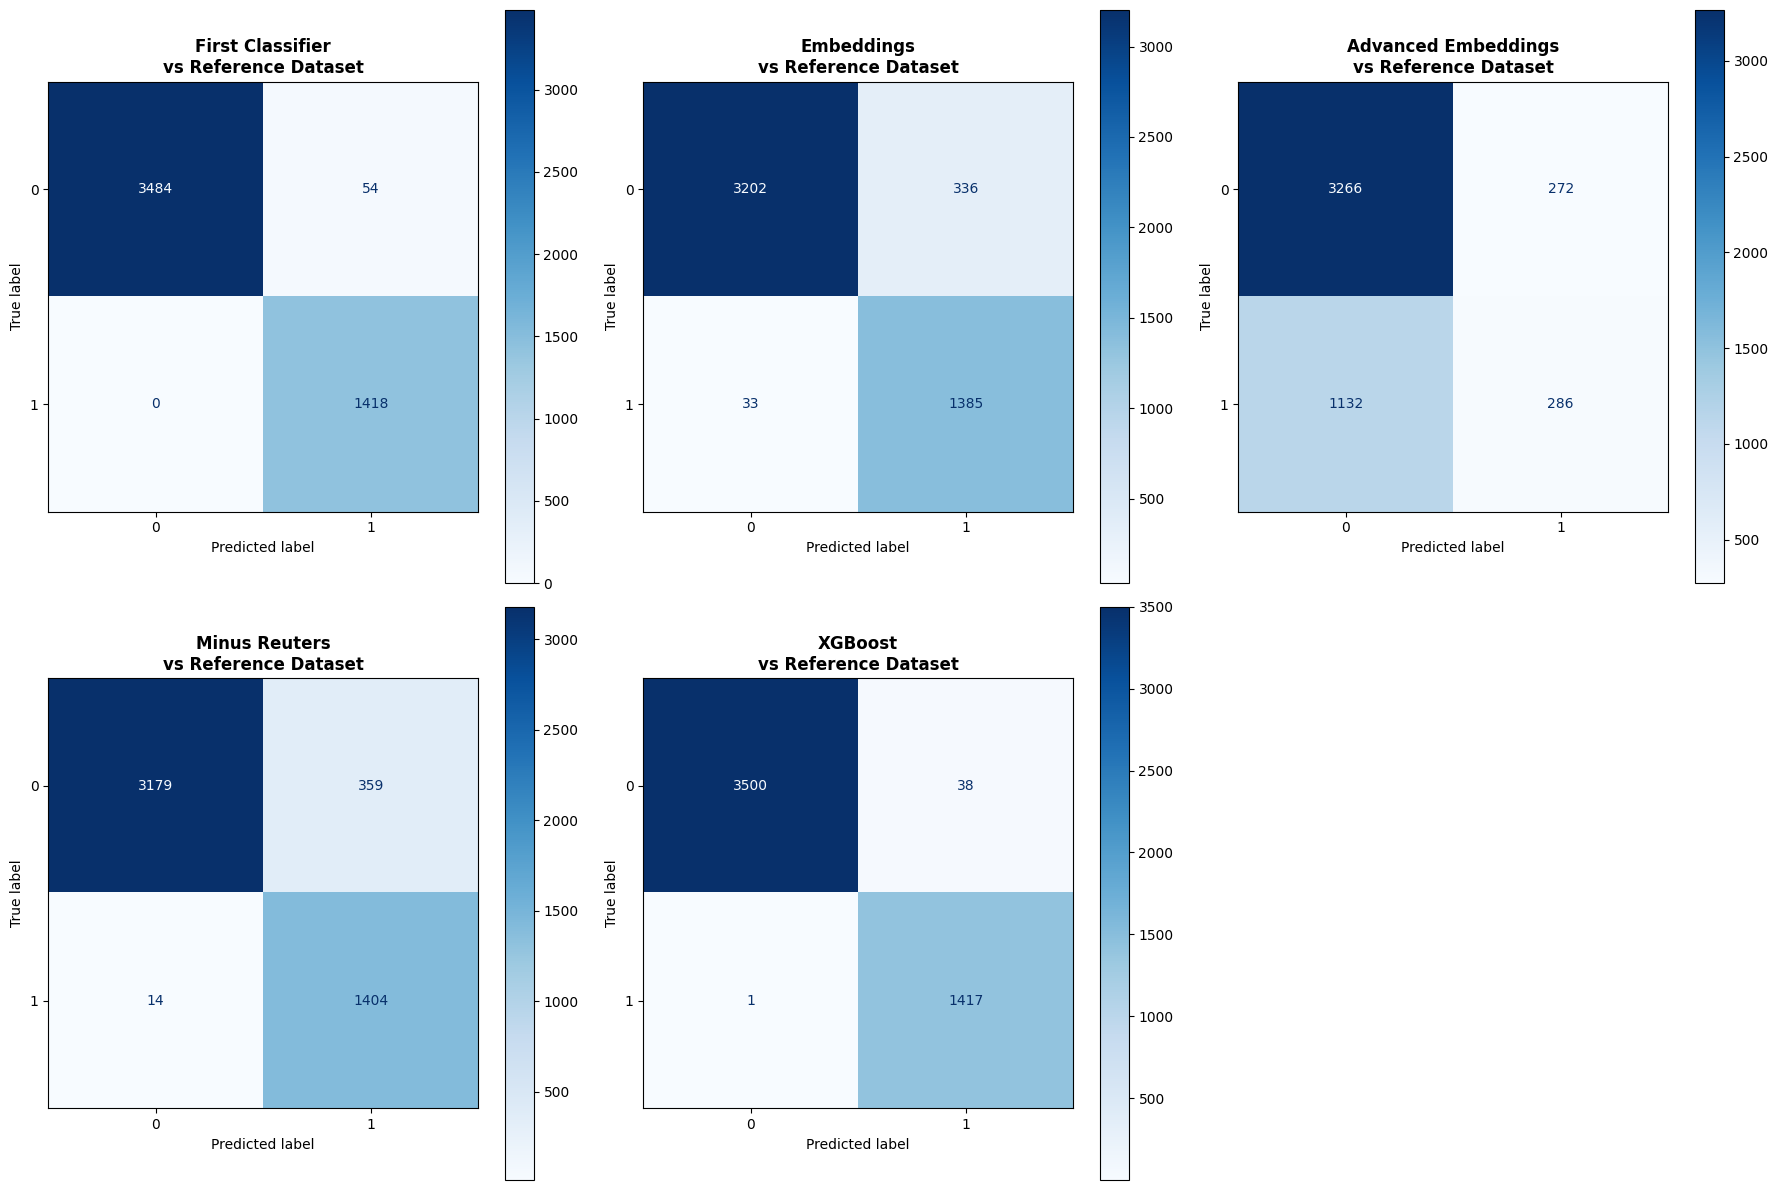

In [ ]:
# Create confusion matrices for all datasets
n_datasets = len([name for name, df in datasets.items() if 'label' in df.columns])
if n_datasets > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    
    for name, df in datasets.items():
        if 'label' in df.columns:
            # Get labels
            y_true = reference_labels
            y_pred = df['label'].values
            
            # Ensure same length
            min_len = min(len(y_true), len(y_pred))
            y_true = y_true[:min_len]
            y_pred = y_pred[:min_len]
            
            # Create confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Plot confusion matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
            disp.plot(ax=axes[plot_idx], cmap='Blues', values_format='d')
            axes[plot_idx].set_title(f'{name}\nvs Reference Dataset', fontweight='bold')
            
            plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No datasets with 'label' column found for confusion matrix creation.")


## Detailed Classification Reports

Generate detailed classification reports for each dataset comparison.


In [ ]:
# Generate detailed classification reports
for name, df in datasets.items():
    if 'label' in df.columns:
        print(f"\n{'='*60}")
        print(f"CLASSIFICATION REPORT: {name}")
        print(f"{'='*60}")
        
        # Get labels
        y_true = reference_labels
        y_pred = df['label'].values
        
        # Ensure same length
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        
        # Generate classification report
        report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
        print(report)
        
        # Additional statistics
        print(f"Total samples compared: {len(y_true)}")
        print(f"Agreement rate: {accuracy_score(y_true, y_pred):.4f}")
        
        # Count disagreements
        disagreements = (y_true != y_pred).sum()
        print(f"Total disagreements: {disagreements} ({disagreements/len(y_true)*100:.2f}%)")
        
        # Show disagreement breakdown
        if disagreements > 0:
            disagreement_df = pd.DataFrame({
                'Reference': y_true[y_true != y_pred],
                'Predicted': y_pred[y_true != y_pred]
            })
            print("\nDisagreement breakdown:")
            print(disagreement_df.value_counts().to_string())
    else:
        print(f"\nSkipping {name} - no 'label' column found")



CLASSIFICATION REPORT: First Classifier
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99      3538
     Class 1       0.96      1.00      0.98      1418

    accuracy                           0.99      4956
   macro avg       0.98      0.99      0.99      4956
weighted avg       0.99      0.99      0.99      4956

Total samples compared: 4956
Agreement rate: 0.9891
Total disagreements: 54 (1.09%)

Disagreement breakdown:
Reference  Predicted
0          1            54

CLASSIFICATION REPORT: Embeddings
              precision    recall  f1-score   support

     Class 0       0.99      0.91      0.95      3538
     Class 1       0.80      0.98      0.88      1418

    accuracy                           0.93      4956
   macro avg       0.90      0.94      0.91      4956
weighted avg       0.94      0.93      0.93      4956

Total samples compared: 4956
Agreement rate: 0.9255
Total disagreements: 369 (7.45%)

Disagreement breakdown:
Ref

## Metrics Visualization

Create visualizations to compare key metrics across datasets.


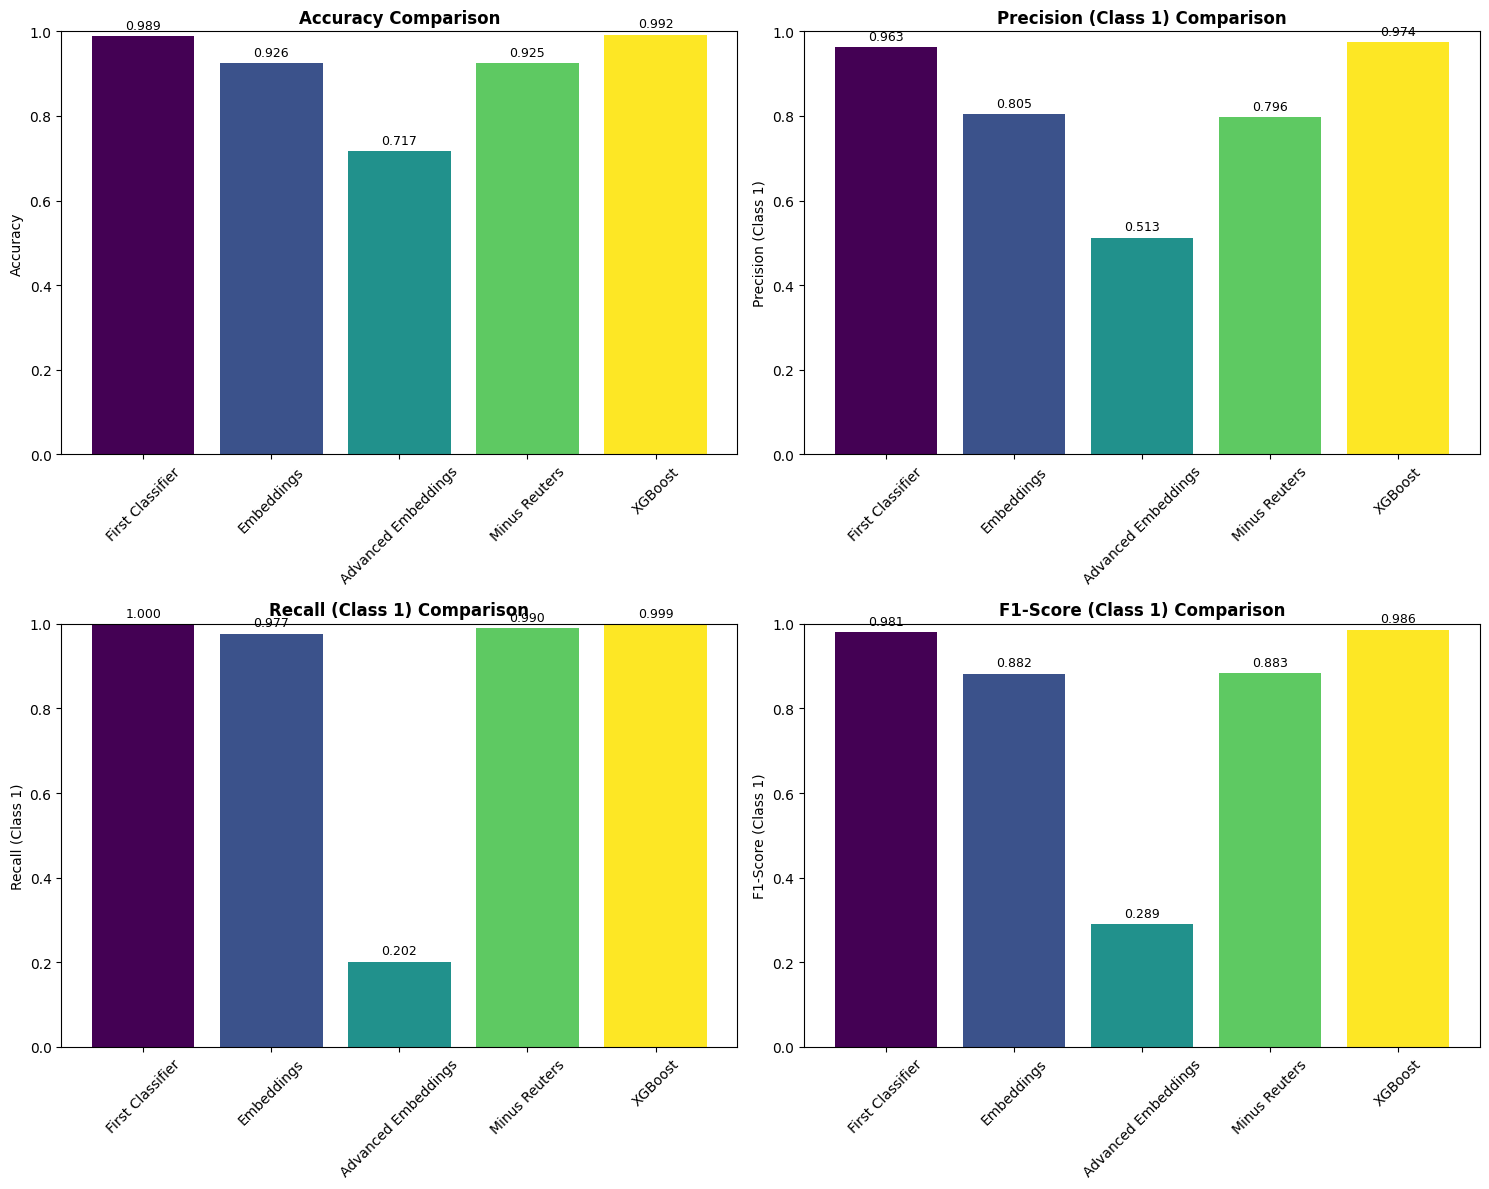

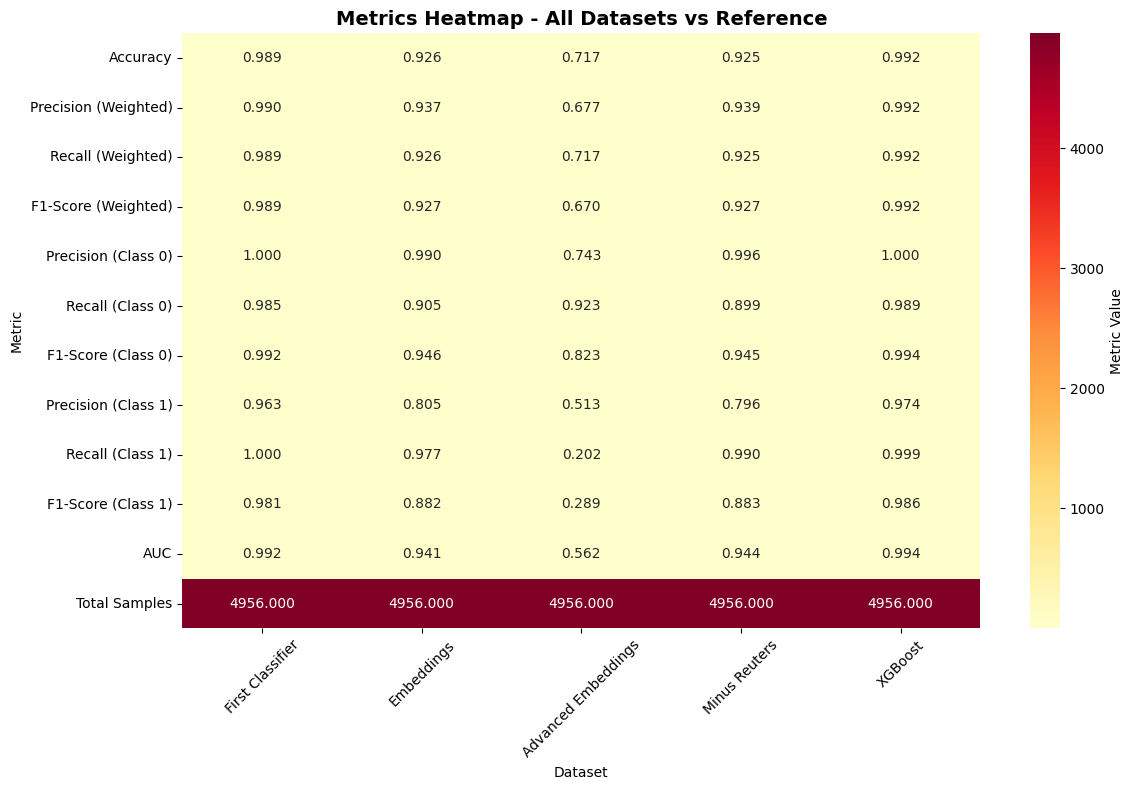

In [ ]:
if 'metrics_df' in locals() and len(metrics_df) > 0:
    # Create metrics comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Key metrics to plot
    key_metrics = ['Accuracy', 'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)']
    
    for i, metric in enumerate(key_metrics):
        ax = axes[i//2, i%2]
        
        # Create bar plot
        bars = ax.bar(metrics_df['Dataset'], metrics_df[metric], 
                     color=plt.cm.viridis(np.linspace(0, 1, len(metrics_df))))
        
        ax.set_title(f'{metric} Comparison', fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        
        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, metrics_df[metric]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of all metrics
    plt.figure(figsize=(12, 8))
    
    # Select numeric columns for heatmap
    heatmap_data = metrics_df.set_index('Dataset')[numeric_columns].T
    
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
                cbar_kws={'label': 'Metric Value'})
    plt.title('Metrics Heatmap - All Datasets vs Reference', fontweight='bold', fontsize=14)
    plt.xlabel('Dataset')
    plt.ylabel('Metric')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No metrics data available for visualization.")


## Summary and Conclusions

Based on the analysis above, we can draw the following conclusions:


In [ ]:
if 'metrics_df' in locals() and len(metrics_df) > 0:
    print("\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)
    
    # Find best performing dataset for each metric
    key_metrics = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
    
    print("\nBest performing dataset for each metric:")
    for metric in key_metrics:
        best_idx = metrics_df[metric].idxmax()
        best_dataset = metrics_df.loc[best_idx, 'Dataset']
        best_value = metrics_df.loc[best_idx, metric]
        print(f"  {metric}: {best_dataset} ({best_value:.4f})")
    
    # Overall ranking based on F1-score
    print("\nOverall ranking (by F1-Score):")
    ranking = metrics_df.sort_values('F1-Score (Weighted)', ascending=False)
    for i, (_, row) in enumerate(ranking.iterrows(), 1):
        print(f"  {i}. {row['Dataset']}: {row['F1-Score (Weighted)']:.4f}")
    
    # Dataset with highest agreement
    best_accuracy_idx = metrics_df['Accuracy'].idxmax()
    best_accuracy_dataset = metrics_df.loc[best_accuracy_idx, 'Dataset']
    best_accuracy_value = metrics_df.loc[best_accuracy_idx, 'Accuracy']
    
    print(f"\nDataset with highest agreement with reference: {best_accuracy_dataset} ({best_accuracy_value:.4f})")
    
    # Calculate average performance
    avg_metrics = metrics_df[key_metrics].mean()
    print("\nAverage performance across all datasets:")
    for metric, value in avg_metrics.items():
        print(f"  {metric}: {value:.4f}")
        
    print("\n" + "="*80)
    print("Analysis completed successfully!")
    print("="*80)
else:
    print("No analysis could be performed due to missing metrics data.")



ANALYSIS SUMMARY

Best performing dataset for each metric:
  Accuracy: XGBoost (0.9921)
  Precision (Weighted): XGBoost (0.9923)
  Recall (Weighted): XGBoost (0.9921)
  F1-Score (Weighted): XGBoost (0.9922)

Overall ranking (by F1-Score):
  1. XGBoost: 0.9922
  2. First Classifier: 0.9892
  3. Embeddings: 0.9275
  4. Minus Reuters: 0.9269
  5. Advanced Embeddings: 0.6704

Dataset with highest agreement with reference: XGBoost (0.9921)

Average performance across all datasets:
  Accuracy: 0.9096
  Precision (Weighted): 0.9068
  Recall (Weighted): 0.9096
  F1-Score (Weighted): 0.9012

Analysis completed successfully!
